In [1]:
#@title Gromov-Wasserstein Barycenters - The Analysis Problem

#Install
!pip install POT

#Import
import numpy as np
import ot
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import scipy as sp
from scipy.spatial import distance_matrix
from scipy.spatial import distance
from sklearn.manifold import MDS
import time
import random

In [2]:
#@title Core functions

def get_lambdas(S, C_list, p_list, D, q):
  """
  get_lambdas computes the barycentric weights (lambda_1,...,lamnda_S) from the simplifyed GW-Barycenter Analysis Problem
  input:
    S: numerber of templates
    C_list: list of S arrays of different dimensions (Ns,Ns),
            each one represents an (Ns x Ns) matrix that is one of the S different dissimilarity matrices of the S templates
    p_list: list of S arrays of fifferent dimensions Ns,
            each one represents a probability vector in R^Ns that is one of the S probability measures of the S templates
    D: matrix representing a dissimilarity matrix you want to analyze (array)
    q: probability vector of size of D (array)
  output:

  """
  pi_list = []
  F_list = []
  Q = (q.reshape(-1,1) @ q.reshape(1,-1))
  Q = 1. / Q

  for s in range(S):
      pi_s = ot.gromov.gromov_wasserstein(C_list[s],D,p_list[s],q)
      pi_list.append(pi_s)
      F_s = Q * (pi_s.T @ C_list[s] @ pi_s)
      F_list.append(F_s)

  K = np.zeros((S,S))
  b = np.zeros(S)
  for i in range(S):
      b[i] = np.trace(D @ F_list[i])
      for j in range(S):
          K[i,j] = np.trace(F_list[i] @ F_list[j])

  K_aug = np.hstack([K, -0.5 * np.ones(S).reshape(-1,1)])
  last_row = np.ones(K_aug.shape[1]).reshape(1,-1)
  last_row[0,-1] = 0
  K_aug = np.vstack([K_aug,last_row])

  b_aug = np.hstack([b, [1]])

  lambdas = np.linalg.solve(K_aug, b_aug)

  ## We still need to add the restriction lambdas[s] >=0
  return lambdas[0:-1]


def projection_guess(num_iter, S, C_list, p_list, D, q, lambdas_list):
  """
  imput:
  output:
  """
  for iteration in range(num_iter):
    pi_list = []
    F_list = []
    Q = (q.reshape(-1,1) @ q.reshape(1,-1))
    Q = 1. / Q

  for s in range(S):
    pi_s = ot.gromov.gromov_wasserstein(C_list[s],D,p_list[s],q)
    pi_list.append(pi_s)
    F_s = Q * (pi_s.T @ C_list[s] @ pi_s)
    F_list.append(F_s)

  D_recon = np.zeros_like(D)
  for s in range(S):
    D_recon += lambdas_list[s] * F_list[s]
    D = D_recon
  return D

In [3]:
#@title Visualization funtions

#@title Plot

def round_to_grid(points, grid_spacing):
    # Compute min and max values for the grid
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)

    # Generate grid points based on the range and grid spacing
    x_grid = np.arange(min_x, max_x + grid_spacing, grid_spacing)
    y_grid = np.arange(min_y, max_y + grid_spacing, grid_spacing)

    # Round each point to the nearest grid corner
    rounded_points = np.empty_like(points)
    for i, (x, y) in enumerate(points):
        # Find the closest grid points
        closest_x = x_grid[np.abs(x_grid - x).argmin()]
        closest_y = y_grid[np.abs(y_grid - y).argmin()]
        rounded_points[i] = [closest_x, closest_y]

    return rounded_points

def determine_grid_spacing_percentage(points, percentage=5):
    # Compute the range of the data
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)
    range_x = max_x - min_x
    range_y = max_y - min_y

    # Choose grid spacing as a percentage of the larger range
    return max(range_x, range_y) * (percentage / 100)

In [4]:
# Create an MDS instance
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)

In [5]:
#@title Download and load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform) #train
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Extract training images and labels
train_images = mnist_dataset.data.float()  # Ensure they are floats for normalization  # A torch tensor of shape [60000, 28, 28]
train_labels = mnist_dataset.targets  # A torch tensor of shape [60000]

In [6]:
#@title Function that converts an MNIST image into a 2D point cloud
def mnist_to_point_cloud(image, threshold=0.1):
    """Convert an MNIST image (28x28) to a point cloud by using non-zero pixels."""
    image = image.squeeze()  # Remove channel dimension (1x28x28 -> 28x28)
    points = np.argwhere(image > threshold)  # Get coordinates of pixels above the threshold
    return points.T

In [30]:
#@title Generate Dataset: References and Targets

# Parameters
digit = 3
nref_digit = 4
ntarg_digit = 50

# Find indices for the selected digit
indices = [i for i, label in enumerate(train_labels) if label == digit]

# Shuffle the indices
perm = np.random.permutation(len(indices))

# Select reference and target indices
ref_inds = perm[:nref_digit]
targ_inds = perm[nref_digit:nref_digit + ntarg_digit]

# Extract reference and target digits
ref_digits = train_images[indices][ref_inds]  # Index using PyTorch tensors
targ_digits = train_images[indices][targ_inds]

# Normalize the digits
#ref_digits = ref_digits / ref_digits.sum(dim=(1, 2), keepdim=True)
#targ_digits = targ_digits / targ_digits.sum(dim=(1, 2), keepdim=True)

In [31]:
#@title Perturb the Dataset by Occlussion

mask = np.ones((28,28))
mask[10:18,10:18] = 0

ref_perts = [] # apply the mask
targ_perts = [] # apply the mask

for i in range(nref_digit):
    #ref_digits[i] = ref_digits[i] / ref_digits[i].sum()
    ref_pert = ref_digits[i] * mask
    #ref_pert = ref_pert / ref_pert.sum()
    ref_perts += [ref_pert]

for i in range(ntarg_digit):
    #targ_digits[i] = targ_digits[i] / targ_digits[i].sum()
    targ_pert = targ_digits[i] * mask
    #targ_pert = targ_pert / targ_pert.sum()
    targ_perts += [targ_pert]

In [32]:
#@title Convert the Images in the Dataset to Point Clouds, compute distance matrices, and uniform measures

ref_digits_points = []
targ_digits_points = []

ref_list = []
ref_p_list = []

targ_list = []
targ_q_list = []

for i in range(nref_digit):
    points = mnist_to_point_cloud(ref_digits[i])
    ref_digits_points += [points]
    dist_matrix = distance_matrix(points, points)
    ref_list += [dist_matrix]
    p = np.ones(dist_matrix.shape[0]) / dist_matrix.shape[0]
    ref_p_list += [p]

for i in range(ntarg_digit):
    points = mnist_to_point_cloud(targ_digits[i])
    targ_digits_points += [points]
    dist_matrix = distance_matrix(points, points)
    targ_list += [dist_matrix]
    q = np.ones(dist_matrix.shape[0]) / dist_matrix.shape[0]
    targ_q_list += [q]


## Perturbed case

ref_pert_points = []
targ_pert_points = []

ref_pert_list = []
ref_p_pert_list = []

targ_pert_list = []
targ_q_pert_list = []

for i in range(nref_digit):
    points = mnist_to_point_cloud(ref_perts[i])
    ref_pert_points += [points]
    dist_matrix = distance_matrix(points, points)
    ref_pert_list += [dist_matrix]
    p = np.ones(dist_matrix.shape[0]) / dist_matrix.shape[0]
    ref_p_pert_list += [p]

for i in range(ntarg_digit):
    points = mnist_to_point_cloud(targ_perts[i])
    targ_pert_points += [points]
    dist_matrix = distance_matrix(points, points)
    targ_pert_list += [dist_matrix]
    q = np.ones(dist_matrix.shape[0]) / dist_matrix.shape[0]
    targ_q_pert_list += [q]

In [40]:
#@title Recover lambdas iteratively

num_ite = 10   # Maximum number of iterations
tol = 1e-4     # Tolerance for error

u = np.random.randint(0,ntarg_digit)

D_new = targ_pert_list[u]  # Initialize D_new
q = targ_q_pert_list[u]    # Initialize q

lambdas = np.zeros(nref_digit)  # Initialize lambdas

for ite in range(num_ite):
  lambdas_new = get_lambdas(nref_digit, ref_pert_list, ref_p_pert_list, D_new, q)

  lambdas_diff = np.linalg.norm(lambdas_new-lambdas, ord=1)
  lambdas = lambdas_new

  D_new = projection_guess(1, nref_digit, ref_pert_list, ref_p_pert_list, D_new, q, lambdas)

  # Break the loop if the error is less than the tolerance
  if lambdas_diff < tol:
      print("Error tolerance reached. Stopping iterations.")
      break

D_new = projection_guess(1, nref_digit, ref_list, ref_p_list, D_new, q, lambdas)

In [41]:
lambdas.sum()

1.0

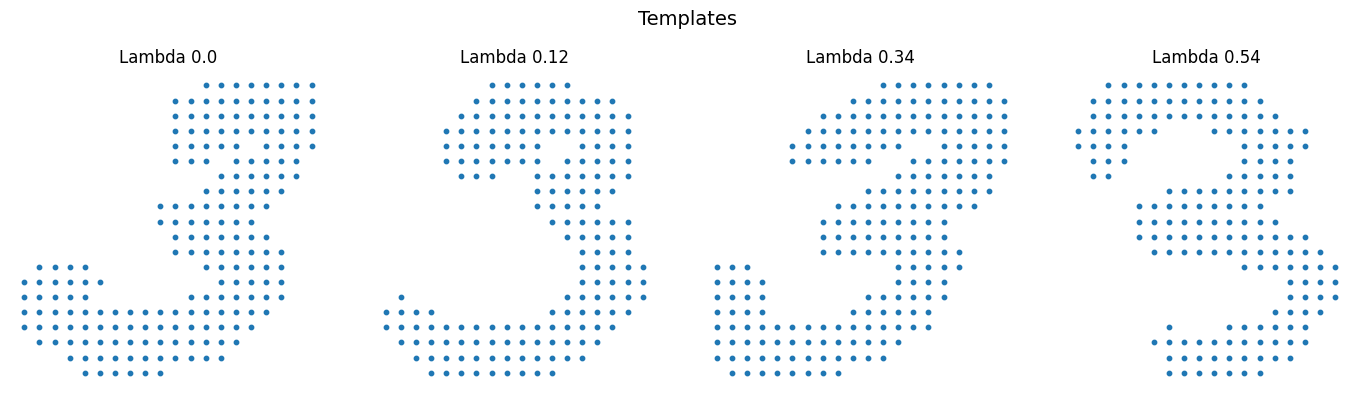

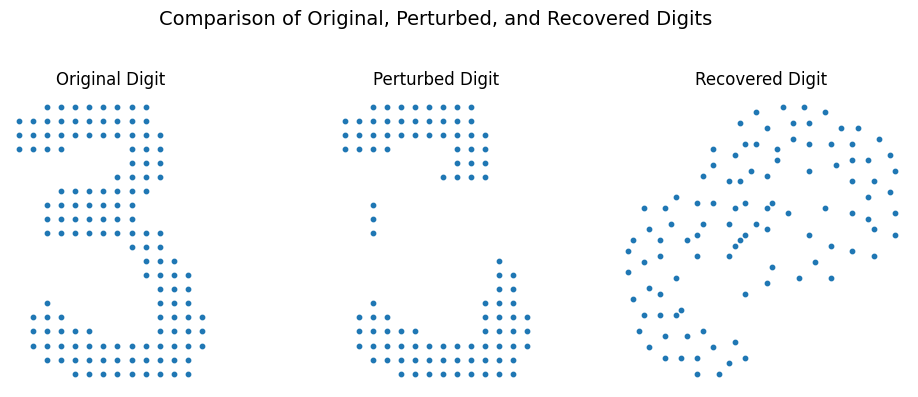

In [42]:
#Templates
fig, axes = plt.subplots(1, nref_digit, figsize=(14, 4))

for i in range(nref_digit):
    points = ref_digits_points[i]
    axes[i].scatter(points[:, 1], -points[:, 0], s=10)
    axes[i].set_title(f'Lambda {round(lambdas[i],2)}')
    axes[i].set_xticks([])  # Remove x-axis ticks
    axes[i].set_yticks([])  # Remove y-axis ticks
    axes[i].set_aspect('equal', adjustable='box')
    axes[i].axis('off')


fig.suptitle('Templates', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle

#Target, perturbed target, and reconstruction
points_D1 = targ_digits_points[u]
points_D2 = targ_pert_points[u]

points_D3 = mds.fit_transform(D_new)

grid_spacing = determine_grid_spacing_percentage(points_D3, percentage=2)
points_D3 = round_to_grid(points_D3, grid_spacing)

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].scatter(points_D1[:, 1], -points_D1[:, 0], s=10)
axes[0].set_title('Original Digit')
axes[0].set_xticks([])  # Remove x-axis ticks
axes[0].set_yticks([])  # Remove y-axis ticks

axes[1].scatter(points_D2[:, 1], -points_D2[:, 0], s=10)
axes[1].set_title('Perturbed Digit')
axes[1].set_xticks([])  # Remove x-axis ticks
axes[1].set_yticks([])  # Remove y-axis ticks

axes[2].scatter(points_D3[:, 1], -points_D3[:, 0], s=10)
axes[2].set_title('Recovered Digit')
axes[2].set_xticks([])  # Remove x-axis ticks
axes[2].set_yticks([])  # Remove y-axis ticks

for i in range(3):
    axes[i].set_aspect('equal', adjustable='box')
    axes[i].axis('off')

fig.suptitle('Comparison of Original, Perturbed, and Recovered Digits', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
# Adjust layout to avoid overlap
#plt.tight_layout()

plt.show()